In [4]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy
from scipy.stats import wilcoxon, ttest_ind
import matplotlib.pyplot as plt
from scipy.stats import kstest

import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.callbacks import EarlyStopping

import random
import warnings

warnings.filterwarnings("ignore")

In [14]:
class Reinforced_DNN:
    def __init__(self,
                 state_space, 
                 action_space, 
                 input_dim = None, 
                 activation = "relu", 
                 input_units = 12,
                 learning_rate=0.1, 
                 discount_factor=0.9, 
                 exploration_rate=1.0, 
                 exploration_decay=0.995):

        self.model = None
        self.input_units_DNN = input_units
        self.activation_DNN = activation
        self.input_dim_DNN = input_dim
        # print(input_dim)
        # self.state_space = state_space
        # self.action_space = action_space
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.q_table = np.zeros((state_space, action_space))

        self.final_performance = []
        self.initial_performance = []
        self.performance_improvement = []
        self.drift_points = []
        
        self.state_ref_data = {}
        self.state_ref_weights = {}
        self.number_of_actions = 0
        self.model_current_state = 0
        self.action_threshold = action_space

        self.display_loss = []
        self.dispaly_accuracy = []
        
    class DNN_model(Model):
        def __init__(self, parent):
            super(Reinforced_DNN.DNN_model, self).__init__()
            
            self.dense1 = Dense(units = parent.input_units_DNN, activation = parent.activation_DNN, input_dim = parent.input_dim_DNN)
            self.dense2 = Dense(units = parent.input_units_DNN * 2, activation = parent.activation_DNN)
            self.dense3 = Dense(units = parent.input_units_DNN * 4, activation = parent.activation_DNN)
            self.dense4 = Dense(units = parent.input_units_DNN * 2, activation = parent.activation_DNN)
            self.dense5 = Dense(units = parent.input_units_DNN, activation = parent.activation_DNN)
            
            self.output_layer = Dense(units = 1, activation = parent.activation_DNN)

        def call(self,  x):
            x = self.dense1(x)
            x = self.dense2(x)
            x = self.dense3(x)
            x = self.dense4(x)
            x = self.dense5(x)
            
            x = self.output_layer(x)
            return x
            
    # Custom callback to stop training at desired accuracy
    # @tf.function(jit_compile = True)
    class StopAtAccuracy(tf.keras.callbacks.Callback):
        def __init__(self, target, target_loss, patience = 5):
            super(Reinforced_DNN.StopAtAccuracy, self).__init__()
            self.target_accuracy = target
            self.target_loss = target_loss * 0.4
            self.patience = patience
            self.max_accuracy = 0
            self.epochs_since_improvement = 0
            
        def on_epoch_end(self, epoch, logs=None):
            current_accuracy = logs.get("accuracy")
            current_loss = logs.get("loss")
            
            # if current_accuracy is not None and current_loss is not None:
            # current_accuracy >= self.target_accuracy and
            if  current_loss < self.target_loss and current_accuracy >= self.target_accuracy:
                print(f"\nTarget accuracy ({self.target_accuracy:.2f}) and loss ({self.target_loss:.2f}) reached. Stopping training.")
                self.model.stop_training = True

            # if current_accuracy > self.max_accuracy:
            #     self.max_accuracy = current_accuracy
            #     self.epochs_since_improvement = 0
            # else:
            #     self.epochs_since_improvement += 1
                
            # if self.epochs_since_improvement == self.patience:
            #     print(f"\nNo improvement in accuracy for {self.patience} consecutive epochs. Stopping training.")
            #     self.model.stop_training = True
            
    # @tf.function(jit_compile= True)
    def create_new_action(self, data, target, target_state, model, previous_loss, target_accuracy = 0.80, init = 0):
        print(f"Model Compiled for new action")
        new_performance_loss = previous_loss + 0.1
        while new_performance_loss > previous_loss:
            if init == 0:
                action_taken = random.choice(range(self.number_of_actions))
            model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=[
                    keras.metrics.BinaryAccuracy(),
                    keras.metrics.FalseNegatives(),
                    "accuracy"
                ],
            )
            if init == 0:
                model.load_weights(self.state_ref_weights[action_taken], skip_mismatch=True)
            print(f"Model Compiled...")
            target_accuracy = target_accuracy
            early_stopping = EarlyStopping(
                monitor='accuracy',          # Monitor the training accuracy
                patience=0,                  # Stop as soon as condition is met
                mode='max',                  # Maximize accuracy
                min_delta=0.001,             # Minimum change to qualify as improvement
                restore_best_weights=True
            )
            stop_at_accuracy = self.StopAtAccuracy(target=target_accuracy, target_loss = previous_loss)
    
            print(f"Model Fitting...")
            print(f"Target loss {previous_loss}")
            model.fit(x= data, y = target, epochs = 100, verbose = 0, callbacks=[stop_at_accuracy])
            new_performance_loss = model.evaluate(data, target, verbose = 0)[0]
            if new_performance_loss > previous_loss:
                print(f"Model training failed, new performance {new_performance_loss} is greater than the previous loss {previous_loss}")

        print(f"Model trained from scratch, new performance loss : {new_performance_loss}")
        
        if self.number_of_actions < self.action_threshold:
            action_taken = self.number_of_actions
            model.save_weights(f"Model_weights/model_action{action_taken}.weights.h5")
            self.state_ref_weights[action_taken] = f"Model_weights/model_action{action_taken}.weights.h5"
            print(f"Model weights for action {action_taken} has been saved at {self.state_ref_weights[action_taken]}")
            reward = previous_loss - new_performance_loss
            
            print(f"Model reward for new action {action_taken} : {reward}\n")
            # self.update_q_table(target_state, action_taken, reward, target_state)
            self.number_of_actions += 1
            
        else :   
            action_taken = self.number_of_actions + 1
            print("Action threshold reached... No new action can be added")
            
        print(f"Total number of actions : {self.number_of_actions}\n")   
        return model, action_taken, reward

    # @tf.function(jit_compile= True)
    def get_action(self, data, target, model, target_state, performance_threshold = 0.75):
        ## This function determines the action that the model must take to achive goo performance
        ## This takes the exploration and exploitation methods to determine its next actions
        dup_model = model
        action = 0 
        reward = 0
        action_taken = 0
        new_performance = 0
        print("Determining action ...")
        
        ## First check the models performanceabs
        current_performance_accuracy = round(model.evaluate(data, target, verbose = 0)[-1], 2)
        previous_loss = round(model.evaluate(data, target, verbose = 0)[0], 2)
        
        if current_performance_accuracy < performance_threshold:
            print(f"Model's current performance {current_performance_accuracy} was less than the threshold : {performance_threshold}")
            # Exploration
            if (random.uniform(0, 1) < self.exploration_rate and self.number_of_actions > 10):
                print("Exploration action taken, model training start...")
                action_taken = random.choice(range(self.number_of_actions))
                model.compile(
                    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                    loss=keras.losses.BinaryCrossentropy(),
                    metrics=[
                        keras.metrics.BinaryAccuracy(),
                        keras.metrics.FalseNegatives(),
                        "accuracy"
                    ],
                )
                model.load_weights(self.state_ref_weights[action_taken], skip_mismatch=True)
                print(f"model weights {action_taken} were loaded")
                # model.fit(x= data, y = target, epochs = 10, verbose = 0)
                # print(f"model {model} was fit using weights {action_taken}\n")
                new_performance_loss = round(model.evaluate(data, target, verbose = 0)[0], 2)
                new_performance_accuracy = round(model.evaluate(data, target, verbose = 0)[-1], 2)
                
                reward = previous_loss - new_performance_loss
                
                if new_performance_loss <= previous_loss:
                    action = action_taken
                else:
                    action = action_taken
                    model = dup_model
                    
                print(f"Model's performance loss before weight fit {previous_loss} \nModel's performance loss after weight fit {new_performance_loss}")
                print(f"Model's performance accuracy before weight fit {current_performance_accuracy} \nModel's performance loss after weight fit {new_performance_accuracy}")
            
            else:       
                # Exploitation
                print("Exploitation action taken, model training start...")
                action_taken = np.argmax(self.q_table[target_state])
                # model.compile(
                #     optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                #     loss=keras.losses.BinaryCrossentropy(),
                #     metrics=[
                #         keras.metrics.BinaryAccuracy(),
                #         keras.metrics.FalseNegatives(),
                #         "accuracy"
                #     ],
                # )
                model.load_weights(self.state_ref_weights[action_taken], skip_mismatch=True)
                print(f"model weights {action_taken} were loaded")
                # model.fit(x= data, y = target, epochs = 10, verbose = 0)
                print(f"model {model} was initialized using weights {action_taken}\n")
                      
                new_performance_loss = round(model.evaluate(data, target, verbose = 0)[0], 2)
                new_performance_accuracy = round(model.evaluate(data, target, verbose = 0)[-1], 2)
                
                reward =  previous_loss - new_performance_loss 
                
                if new_performance_loss < previous_loss:
                    action = action_taken  
                else:
                    print(f"New action created due to inadequate performance in exploit\n")
                    # self.performance_history.append(new_performance_loss)
                    model_res, action_taken, reward_r = self.create_new_action(data, target, target_state, model, previous_loss, performance_threshold)
                    model = model_res
                    action = action_taken
                    reward = reward_r
                    new_performance_loss = round(model.evaluate(data, target, verbose = 0)[0], 2)
                    new_performance_accuracy = round(model.evaluate(data, target, verbose = 0)[-1], 2)
                    
                print(f"Model's performance loss before weight fit {previous_loss} \nModel's performance loss after weight fit {new_performance_loss}")
                print(f"Model's performance accuracy before weight fit {current_performance_accuracy} \nModel's performance loss after weight fit {new_performance_accuracy}")
                
        elif current_performance_accuracy >= performance_threshold:
            print(f"No significant change in performance accuracy, so no new action\n")
            action = 0 
            reward = 0 
            new_performance_loss = previous_loss
            print(f"Model's performance loss before weight fit {previous_loss} \nModel's performance loss after weight fit {new_performance_loss}")
            print(f"Model's performance accuracy before weight fit {current_performance_accuracy} \nModel's performance loss after weight fit {current_performance_accuracy}")

        print(f"\nAction determination done")    
        
        print(f"Action taken : {action} \nReward : {reward}\n")
        return action, reward, new_performance_loss, model
        
    
    def update_q_table(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        self.q_table[state, action] += self.learning_rate * (reward + self.discount_factor * self.q_table[next_state, best_next_action] - self.q_table[state, action])
    
    def decay_exploration(self):
        self.exploration_rate *= self.exploration_decay

    def init_state(self, state, data):
        self.state_ref_data[state] = data
        return state
        
    def determine_state(self, current_data, wil_p_value = 0.5, evaluation = 0):
        print(f"Number of states available {len(self.state_ref_data)}")
        state_iter = 0
        target = 10000
        max_state = 0
        similarity_score = []
        
        for state_iter, ref_data in enumerate(self.state_ref_data):
            # print(f"The current state {current_data}")
            # print(f"The reference state {self.state_ref_data[ref_data]}\n")
            # res = wilcoxon(x = current_data, y = self.state_ref_data[ref_data])
            res = ttest_ind(a=current_data, b=self.state_ref_data[ref_data], equal_var=True)
            similar_columns = list(res[1] <= np.full(res[1].shape, wil_p_value)).count(True)
            if similar_columns > 2:
                if similar_columns > max_state:
                    target = state_iter
                    similarity_score = res[1]
                    max_state = similar_columns
        if target != 10000:    
            print(f"The similarity score of target state {target} : {similarity_score}")
            # print(f"The truth values with w_p-value {wil_p_value} is : {list(res[1] <= np.full(res[0].shape, wil_p_value)).count(True)}")
            # target = state_iter
        
        elif target == 10000:
            if evaluation == 0:  
                print(f"No appropriate state found in the existing list, creating new state") 
                state_iter += 1
                target = self.init_state(state_iter, current_data)
                print(f"New state {target} created")
                print(f"Target state : {target}")
                res = ttest_ind(a=current_data, b=self.state_ref_data[ref_data], equal_var=True)
                similar_columns = list(res[1] > np.full(res[1].shape, 0.05)).count(True)
                
                print(f"Number of similar columns {similar_columns}\n")
                
            if evaluation == 1:
                eval_will_p_value = wil_p_value
                print(f"Similar state not found, finding the next best option...")
                
                while(target == 10000):
                    max_state_columns = 0
                    eval_will_p_value -= 0.2 * eval_will_p_value
                    print(f"Search with p_value {eval_will_p_value}...")
                    for state_iter, ref_data in enumerate(self.state_ref_data):
                        res = ttest_ind(a=current_data, b=self.state_ref_data[ref_data], equal_var=True)
                        similar_columns = list(res[1] > np.full(res[1].shape, eval_will_p_value)).count(True)
                        if similar_columns > 2:
                            if similar_columns > max_state_columns:
                                target = state_iter
                                similarity_score = res[1]
                                max_state_columns = similar_columns
                    
                    if target == 10000:
                        print("Search failed, retrying...\n")
                if target == 10000:
                    print(f"\nNo state found, assigning random state")
                    target = random.choice(range(len(self.state_ref_data)))
                else:
                    print(f"The similarity score of target state {target} : {similarity_score}\n")            

        return target

    def detect_drift(self, data, ref_data, ks_pvalue = 0.05):
        test_stat = kstest(data, ref_data)
        if list(test_stat[1] < np.full(test_stat[1].shape, ks_pvalue)).count(True) > 3:
            return 1, test_stat
        else:
            return 0, test_stat
        
    def train_with_drift_detection(self, model, X_train, y_train, n_episodes = 1000, batch_size = 32, performance_threshold = 0.75, ks_pvalue = 0.05, wil_p_value = 0.05):
        # model_current_state = 0
        # print(n_episodes)
        prev_loss = 0
        for episode in range(n_episodes):
            pos = random.randint(0, len(X_train) - batch_size)
            batch_X = X_train[pos:pos+batch_size]
            batch_y = y_train[pos:pos+batch_size]
            
            # print(batch_X.shape)
            if episode != 0:
                detect_drifted, detected_stat = self.detect_drift(batch_X, prev_data_x, ks_pvalue = ks_pvalue)
                # target_state_eval = self.determine_state(batch_X, wil_p_value = wil_p_value, evaluation=1)
                
                # prev_loss = self.model.evaluate(prev_data_x, prev_data_y, verbose = 0)[0]
                current_model_loss = self.model.evaluate(batch_X, batch_y, verbose = 0)[0]
                
            if (episode == 0):
                print("Start Training ...")
                self.initial_performance.append(self.model.evaluate(batch_X, batch_y, verbose = 0)[0])
                model(batch_X)
                self.model_current_state = self.init_state(0 , batch_X) #Model state initialization = 0
                print(f"Model initialized with state {self.model_current_state}")
                r_model, action, reward = self.create_new_action(batch_X, batch_y, 0, model, 1, performance_threshold, init = 1)
                print(f"Model created with action {action} with accuracy {model.evaluate(batch_X, batch_y, verbose = 0)[-1]}")
                self.model  = r_model
                prev_data_x = batch_X
                prev_data_y = batch_y
                prev_loss = self.model.evaluate(batch_X, batch_y, verbose = 0)[0]
                self.final_performance.append(round(self.model.evaluate(batch_X, batch_y)[0], 2))
                self.performance_improvement.append(reward)
                self.update_q_table(self.model_current_state, action, reward, self.model_current_state)
                
                
            elif (( detect_drifted == 1 or current_model_loss > prev_loss) and episode != 0):
                ## Determine the target state for the model to reach, if there is no state that
                ## currently does not accommodate the data, a new state will be created
                self.initial_performance.append(current_model_loss)
                if detect_drifted == 1:
                    print(f"Drift_detected in episode {episode}")
                    print(f"Statistic values : {detected_stat[0]}")
                    print(f"Statistic p-values : {detected_stat[1]}\n")
                else:
                    print(f"Decline in model's performance in episode {episode}")
                    print(f"Current model loss {current_model_loss}")
                    print(f"Model loss previously {prev_loss}")
                    
                print("Determining State...")
                target_state = self.determine_state(batch_X, wil_p_value = wil_p_value)
                self.drift_points.append(episode)
                action, reward, performance,r_model = self.get_action(batch_X, batch_y, self.model, target_state, performance_threshold = performance_threshold)
                final_action = action
                self.model = r_model
                self.final_performance.append(performance)
                self.performance_improvement.append(reward)
                self.model_current_state = target_state
                prev_loss = self.model.evaluate(batch_X, batch_y, verbose = 0)[0]
                self.update_q_table(self.model_current_state, action, reward, target_state)
                prev_data_x = batch_X
                prev_data_y = batch_y
                

            else:
                self.initial_performance.append(current_model_loss)
                print(f"No Drift_detected in episode {episode}")
                print(f"No change in model performance :")
                print(f"previous loss {prev_loss}")
                print(f"current loss {current_model_loss}\n")
                
                print("No action performed")
                self.final_performance.append(current_model_loss)
                self.performance_improvement.append(0)
                ## Updating to the model's current state as there is no state change detected (drift) in this case
                self.update_q_table(self.model_current_state, 0, 0, self.model_current_state)
                prev_data_x = batch_X
                prev_data_y = batch_y
                prev_loss = current_model_loss
            
            # Decay exploration
            self.decay_exploration()
            print(f"Episode {episode} done...\n")
            print("="*70,"\n")
        
        return self.initial_performance, self.final_performance, self.performance_improvement, self.drift_points, self.model   

    def plot_results(self, performance_data, drift_data, indicate_drift = 1):
        plt.plot(performance_data)
        if indicate_drift == 1:
            for point in drift_points:
                plt.axvline(x= point, color = "red", linestyle = "dotted")

    #Apply styling to the dataframe (Q-table)
    def highlight_max_and_threshold(row):
        max_value = row.max()  # Find the max value in the row
        styles = []
        for value in row:
            if value == max_value:
                styles.append('background-color: blue')  # Highlight max value
            elif value > 0.0:
                styles.append('background-color: green')  # Highlight values over threshold
            elif value < 0.0:
                styles.append('background-color: red')
            else:
                styles.append('')  # No styling for other cells          
        return styles
        
    def display_q_table(self):
        pd.set_option("display.max_columns", 100)
        pd.set_option("display.max_rows", 100)
        
        df = pd.DataFrame(self.q_table[:,:self.number_of_actions])
        styled_df = df.head(len(self.state_ref_data)).style.apply(highlight_max_and_threshold, axis = 1)
        
        return styled_df
    
    def initialize_train_model(self, X_train, y_train, n_episodes = 1000, batch_size = 32, performance_threshold = 0.75, ks_pvalue = 0.05, wil_p_value = 0.05):
        self.model = self.DNN_model(self)
        self.model(X_train)
        self.model.compile(
                    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                    loss=keras.losses.BinaryCrossentropy(),
                    metrics=[
                        keras.metrics.BinaryAccuracy(),
                        keras.metrics.FalseNegatives(),
                        "accuracy"
                    ],
                )
        self.model.summary()
        print(n_episodes)
        initial_history, final_history, improvement_history, drift_points, model = self.train_with_drift_detection(self.model, 
                                                                       X_train, 
                                                                       y_train, 
                                                                       n_episodes = n_episodes, 
                                                                       batch_size = batch_size, 
                                                                       performance_threshold = performance_threshold,
                                                                       ks_pvalue = ks_pvalue, 
                                                                       wil_p_value = wil_p_value)
        
        self.model = model
        return model, initial_history, final_history, improvement_history, drift_points

    def evaluate_model(self, X_test, y_test, batch_size = 32, n_episodes = 1000,  wil_p_value = 0.5, verbose = 1):
        model = self.model
        pos = random.randint(0, len(X_test) - batch_size)
        batch_X = X_test[pos:pos+batch_size]
        batch_y = y_test[pos:pos+batch_size]
        acc_list = []
        loss_list = []
        for episode in range(n_episodes):
            
            target_state = self.determine_state(batch_X, wil_p_value = wil_p_value, evaluation = 1)
            action_taken = np.argmax(self.q_table[target_state])

            # self.model.compile(
            #         optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            #         loss=keras.losses.BinaryCrossentropy(),
            #         metrics=[
            #             keras.metrics.BinaryAccuracy(),
            #             keras.metrics.FalseNegatives(),
            #             "accuracy"
            #         ],
            # )
            self.model.load_weights(self.state_ref_weights[action_taken], skip_mismatch=True)
            model_accuracy = self.model.evaluate(batch_X, batch_y, verbose = 0)[-1]
            model_loss = self.model.evaluate(batch_X, batch_y, verbose = 0)[0]
            if (episode == 0):
                print("Starting Evaluation...")
                prev_model_accuracy = model_accuracy
                prev_model_loss = model_loss
                
            acc_list.append(model_accuracy)
            loss_list.append(model_loss)
            
        self.dispaly_accuracy = acc_list
        self.display_loss = loss_list
        print(f"Average loss of the model : {np.mean(model_loss)}")
        print(f"Standard deviation loss of the model : {np.std(model_loss)}")
        print(f"Maximum loss of the model : {np.max(model_loss)}")
        print(f"Minimum loss of the model : {np.min(model_loss)}\n")
        
        print(f"Average accuracy of the model : {np.mean(model_accuracy)}")
        print(f"Standard deviation accuracy of the model : {np.std(model_accuracy)}")
        print(f"Maximum accuracy of the model : {np.max(model_accuracy)}")
        print(f"Minimum accuracy of the model : {np.min(model_accuracy)}\n")

        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax[0].set_ylim(min(self.dispaly_accuracy), max(self.dispaly_accuracy))
        ax[0].plot(self.dispaly_accuracy, color = "red")
        ax[1].set_ylim(min(self.display_loss), max(self.display_loss))
        ax[1].plot(self.display_loss, color = "orange")

        plt.show()
        return None

In [16]:
df = pd.read_csv('linear_sudden_rotation_noise_and_redunce.csv')

# Assuming the label is the last column and features are all others
X = df.iloc[:, :-1].values  # Features (x1, x2, x3, x4, x5)
y = df.iloc[:, -1].values   # Label (binary: 0 or 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
bX_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
batch_X = bX_train[0:0+32]

obj = Reinforced_DNN(
                     100,
                     100,
                     input_dim = batch_X.shape[1], 
                     activation = "relu", 
                     input_units = 12,
                     learning_rate=0.1, 
                     discount_factor=0.9, 
                     exploration_rate=1.0, 
                     exploration_decay=0.995)

with tf.device('/gpu:0'):
    mod, initial_history, final_history, improvement_history, drift_data  = obj.initialize_train_model(bX_train, 
                                                                                                   y_train, 
                                                                                                   n_episodes= 300, 
                                                                                                   batch_size=32, 
                                                                                                   performance_threshold = 0.80, 
                                                                                                   ks_pvalue = 0.01, 
                                                                                                   wil_p_value = 0.6)

Model: "dnn_model_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (80000, 12)            │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (80000, 24)            │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (80000, 48)            │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (80000, 24)            │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (80000, 12)            │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (80000, 1)             │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

300
Start Training ...
Model initialized with state 0
Model Compiled for new action
Model Compiled...
Model Fitting...
Target loss 1

Target accuracy (0.80) and loss (0.40) reached. Stopping training.
Model trained from scratch, new performance loss : 0.3823701739311218
Model weights for action 0 has been saved at Model_weights/model_action0.weights.h5
Model reward for new action 0 : 0.6176298260688782

Total number of actions : 1

Model created with action 0 with accuracy 0.875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8750 - binary_accuracy: 0.8750 - false_negatives_16: 2.0000 - loss: 0.3824
Episode 0 done...


Decline in model's performance in episode 1
Current model loss 0.749835729598999
Model loss previously 0.3823701739311218
Determining State...
Number of states available 1
The similarity score of target state 0 : [0.39703188 0.73751363 0.10333821 0.46701223 0.44935509]
Determining action ...
Model's current performance 0.69 was less than the threshold : 0.8
Exploitat

Number of states available 12
The similarity score of target state 0 : [0.49823876 0.00104856 0.43619855 0.92171552 0.38667302]
Starting Evaluation...
Number of states available 12
The similarity score of target state 0 : [0.49823876 0.00104856 0.43619855 0.92171552 0.38667302]
Number of states available 12
The similarity score of target state 0 : [0.49823876 0.00104856 0.43619855 0.92171552 0.38667302]
Number of states available 12
The similarity score of target state 0 : [0.49823876 0.00104856 0.43619855 0.92171552 0.38667302]
Number of states available 12
The similarity score of target state 0 : [0.49823876 0.00104856 0.43619855 0.92171552 0.38667302]
Number of states available 12
The similarity score of target state 0 : [0.49823876 0.00104856 0.43619855 0.92171552 0.38667302]
Number of states available 12
The similarity score of target state 0 : [0.49823876 0.00104856 0.43619855 0.92171552 0.38667302]
Number of states available 12
The similarity score of target state 0 : [0.4982387

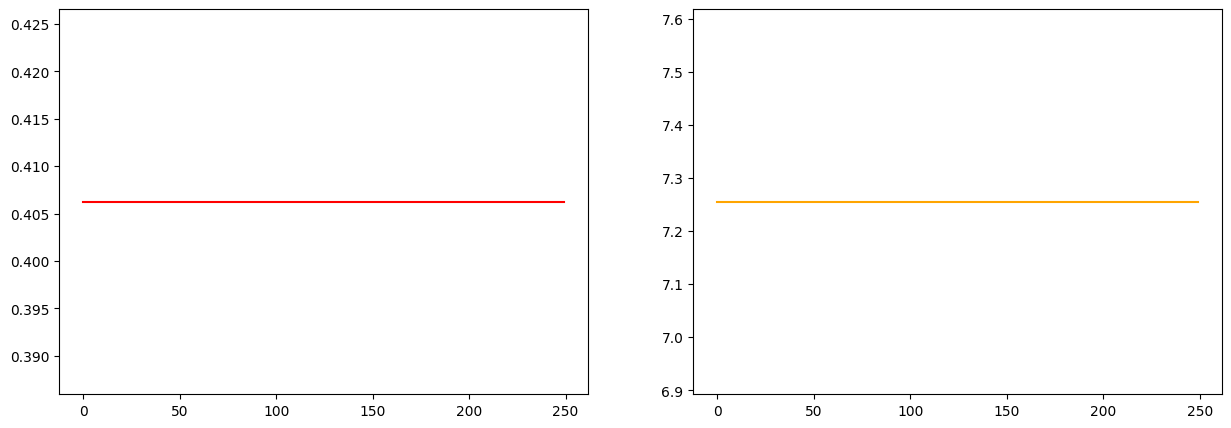

In [22]:
obj.evaluate_model(X_test, y_test, n_episodes=250, wil_p_value = 0.785)

In [21]:
obj.dispaly_accuracy

[]

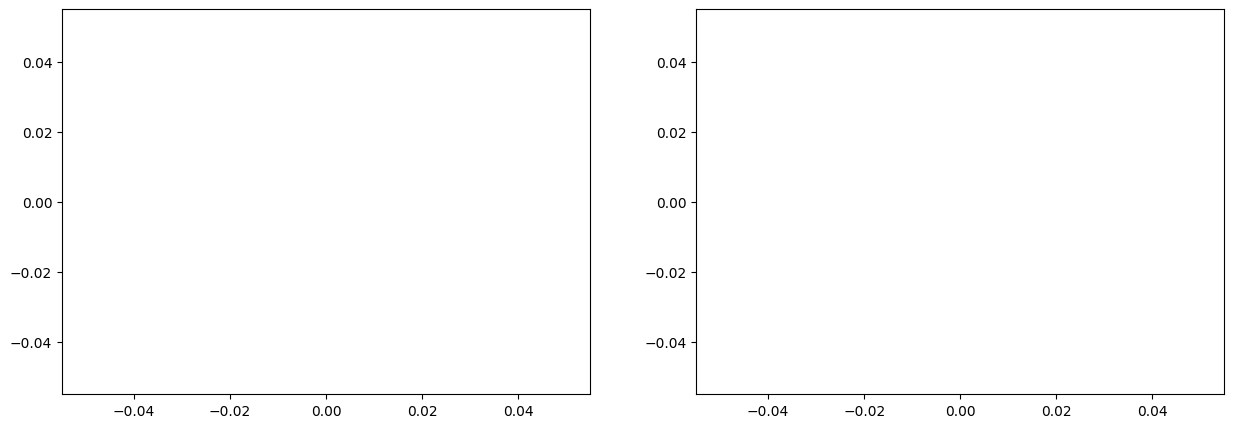

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# ax[0].set_ylim(min(obj.dispaly_accuracy), max(obj.dispaly_accuracy))
ax[0].plot(obj.dispaly_accuracy, color = "red")
# ax[1].set_ylim(min(obj.display_loss), max(self.display_loss))
ax[1].plot(obj.display_loss, color = "orange")

In [40]:
len(drift_data)
len(initial_history)

150

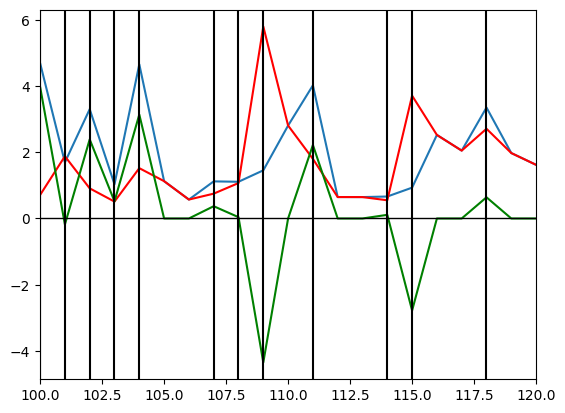

In [36]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(initial_history)
ax.plot(final_history, color = "red")
ax.plot(improvement_history, color = "green")
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
for point in drift_data:
    plt.axvline(point, color = "black")
ax.set_xlim(100,120)  # Expand the x-axis range
# ax.set_ylim(-2, 2)  # Expand the y-axis range

plt.show()

In [26]:
def highlight_max_and_threshold(row):
    max_value = row.max()  # Find the max value in the row
    styles = []
    for value in row:
        if value == max_value:
            styles.append('background-color: blue')  # Highlight max value
        elif value > 0.0:
            styles.append('background-color: green')  # Highlight values over threshold
        elif value < 0.0:
            styles.append('background-color: red')
        else:
            styles.append('')  # No styling for other cells
            
    return styles

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

df = pd.DataFrame(obj.q_table[:,:obj.number_of_actions])
styled_df = df.head(len(obj.state_ref_data)).style.apply(highlight_max_and_threshold, axis = 1)

styled_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.887810,0.000000,1.072370,0.161596,-0.114048,0.203232,-0.029634,0.371479,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.186330,0.140999,0.000000,0.186337,0.000000,0.000000,0.000000
1,0.000000,0.128117,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.161843,0.000000,0.163531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.139353,0.000000,-0.126210,0.000000,-0.010420,0.000000,0.000000,0.074580,0.000000,0.104580,0.000000,0.078580,0.000000,0.000000,0.000000,-0.351405,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.772120,0.000000,0.000000,0.149682,0.108130,2.066880,0.138196,0.152025,0.000000,0.000000,-0.032159,0.130025,0.279682,-0.086894,0.000000,0.000000,0.000000,0.000000,0.202161,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015949,0.000000,0.000000,0.000000,0.095246,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023537,0.000000
5,0.096716,0.000000,-0.016908,0.000000,0.000000,0.247048,-0.211766,0.056092,-0.237028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.354000,0.000000,0.000000,0.042860,0.000000,0.000000,0.000000,0.000000,0.000000,0.003860,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,1.014042,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089750,0.000000,0.000000,0.000000,0.000000
8,0.044463,0.221952,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.123305,0.000000,0.118832,0.000000,0.033325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.022000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [46]:
max(df.iloc[0,:])

1.0867730670144624

In [34]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [1]:
import time
for i in range(1, 6):
    print(f"\rLoading... {i*20}%", end="")
    time.sleep(1)
print("\nDone!")

Loading... 100%
Done!
